In [2]:
!pip install biosignalsnotebooks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 77.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of biosignalsnotebooks to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.4 MB/s eta 

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import biosignalsnotebooks as bsnb
from scipy.signal import iirnotch
from scipy.signal import lfilter,iirfilter,freqz,butter
import scipy
#Estilo de ploteo
plt.style.use("ggplot")
#Lectura de documento txt con tabulación (/t) como delimitador
datos = np.genfromtxt("EJERCICIO_DEV1.txt", delimiter="\t")
print(datos)
#Nos quedamos con los datos del sensor
ecg_datos = datos[:,-2]
ecg_datos
print(ecg_datos)

[[  0.   0.   0. ...   0. 521.  nan]
 [  1.   0.   0. ...   0. 515.  nan]
 [  2.   0.   0. ...   0. 510.  nan]
 ...
 [ 13.   0.   0. ...   0. 541.  nan]
 [ 14.   0.   0. ...   0. 545.  nan]
 [ 15.   0.   0. ...   0. 546.  nan]]
[521. 515. 510. ... 541. 545. 546.]


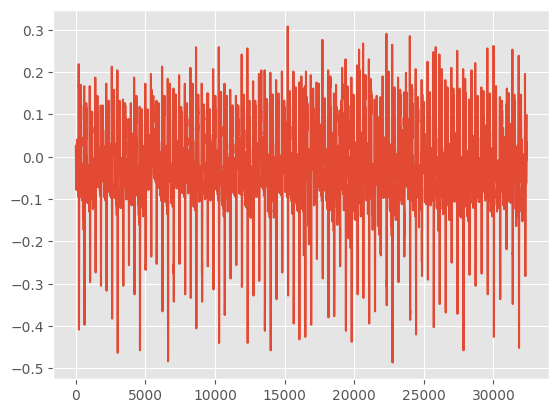

In [44]:
resolution=10
Fs = 1000 #Frecuencia de muestreo del Bitalino
Ts=1/Fs
n = np.arange(0,ecg_datos.shape[0])  # t = n*Ts
t = n*Ts

señal = bsnb.raw_to_phy("ECG", "biosignalsplux", ecg_datos, resolution, "mV")
plt.figure()
plt.plot(señal)
plt.savefig("Cruda_ejercicio.jpg", format='jpg', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Amplitud normalizada')

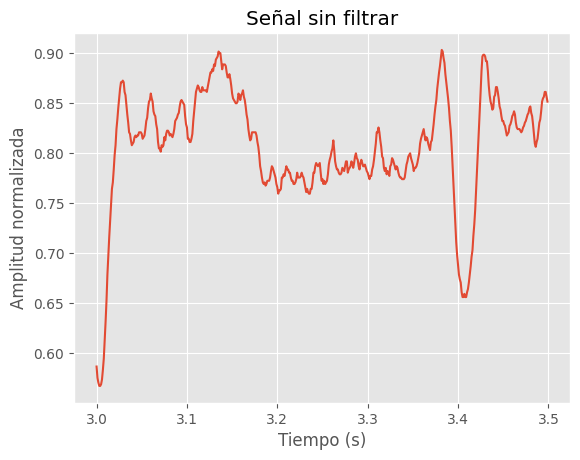

In [45]:
#Graficando los datos
senal_sin_filtrar_norm = ecg_datos / max(abs(ecg_datos)) #Se normalizan los valores
plt.figure()
plt.plot(t[3000:3500],senal_sin_filtrar_norm[3000:3500], label='Señal sin filtrar')
plt.title("Señal sin filtrar")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud normalizada")

(0.0, 100.0)

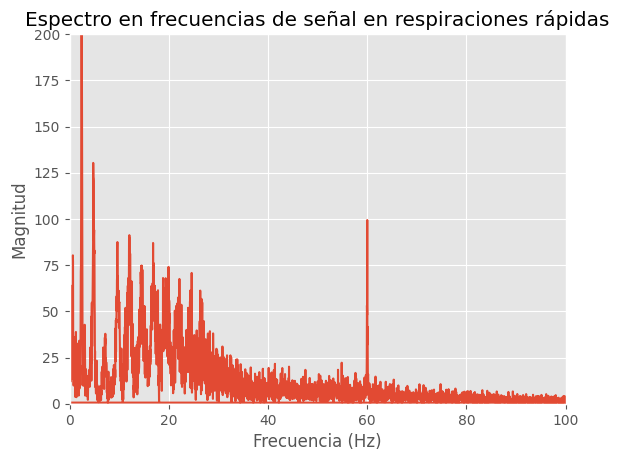

In [46]:
#Procedo a realizar fourier para ver si hay frecuencias ambientales en mi señal
# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin_filtrar_norm)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)

# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin_filtrar_norm))


plt.plot(freqs*1000, mag_signal)
plt.title("Espectro en frecuencias de señal en respiraciones rápidas")
plt.xlabel('Frecuencia (Hz)')  # Usar xlabel() para establecer la etiqueta del eje x
plt.ylabel('Magnitud')          # Usar ylabel() para establecer la etiqueta del eje y
plt.ylim([0, 200])
plt.xlim([0, 100])


(0.0, 100.0)

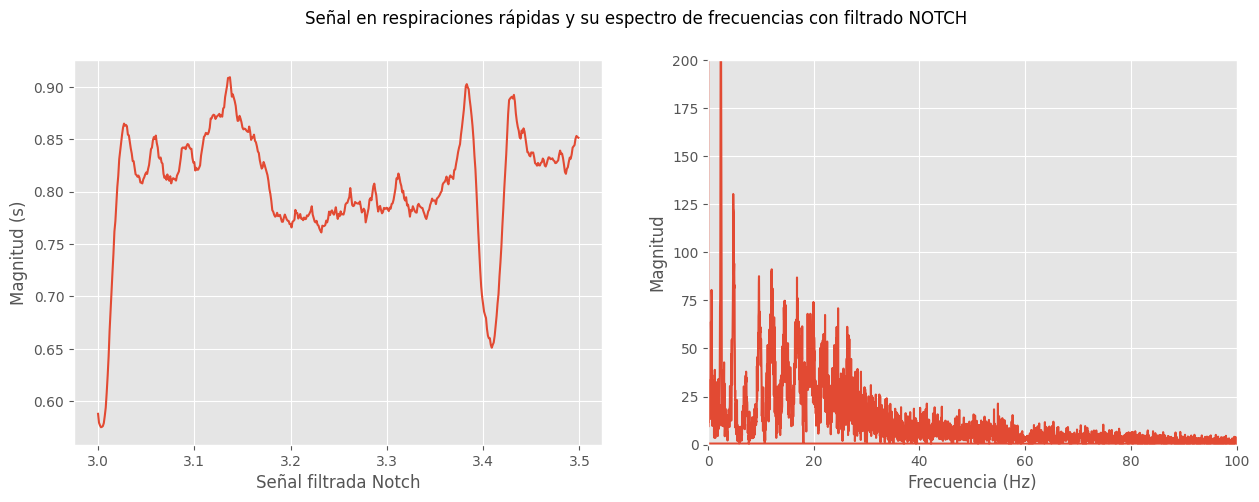

In [48]:
#REALIZAREMOS UN FILTRO NOTCH (RECHAZA DE 60Hz)
# Crear un filtro notch centrado en 60 Hz
f0 = 60.0  # frecuencia a eliminar
Q = 20.0  # factor de calidad
w0 = f0 / (Fs / 2)
b, a = iirnotch(w0, Q)

# Aplicar el filtro notch a la señal
senal_sin60Hz = scipy.signal.lfilter(b, a, senal_sin_filtrar_norm)
# Transformada de Fourier
fft_signal = np.fft.fft(senal_sin60Hz)

# Magnitud de la transformada de Fourier
mag_signal = np.abs(fft_signal)
# Frecuencias
freqs = np.fft.fftfreq(len(senal_sin60Hz))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Señal en respiraciones rápidas y su espectro de frecuencias con filtrado NOTCH")
axs[0].plot(t[3000:3500],senal_sin60Hz[3000:3500], label='Señal filtrada Notch')
axs[0].set_xlabel("Señal filtrada Notch")
axs[0].set_ylabel("Magnitud (s)")

axs[1].plot(freqs*1000, mag_signal)
axs[1].set_xlabel('Frecuencia (Hz)')
axs[1].set_ylabel("Magnitud")
axs[1].set_ylim([0, 200])
axs[1].set_xlim([0, 100])


In [49]:
#FILTRO FIR (HANNING)
# Calcular la respuesta en frecuencia del filtro FIR
FC_FIR = 0.5  # Frecuencia de corte del filtro en Hz
num_taps=101
fir_filter_hanning = scipy.signal.firwin(num_taps, FC_FIR, window='hann')
freq_response_hanning, freqs_hanning = scipy.signal.freqz(fir_filter_hanning, worN=8000)


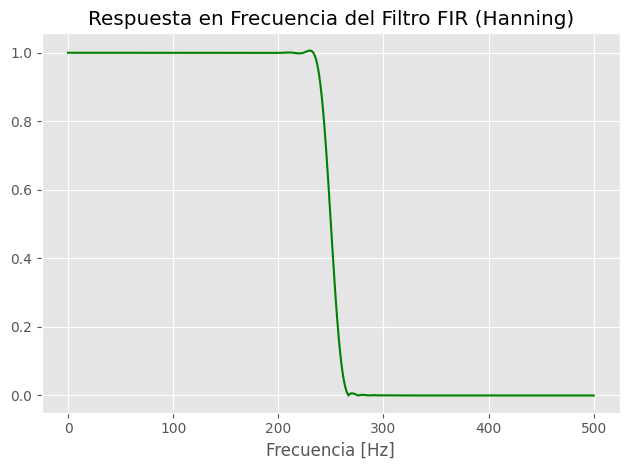

In [50]:
plt.plot(0.5*Fs*freq_response_hanning/np.pi, np.abs(freqs_hanning), 'g')
plt.title('Respuesta en Frecuencia del Filtro FIR (Hanning)')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.tight_layout()

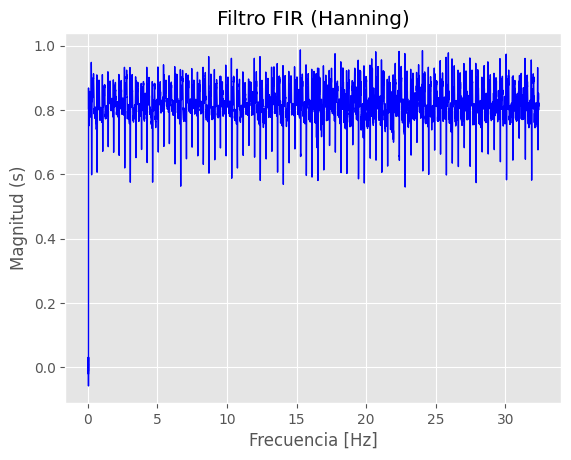

In [51]:
ecg_fir = lfilter(fir_filter_hanning, 1.0, senal_sin60Hz)
plt.plot(t,ecg_fir, lw=1, color='blue')
plt.title('Filtro FIR (Hanning)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel("Magnitud (s)")
plt.savefig("FIR_EJERCICIO.jpg", format='jpg', dpi=300, bbox_inches='tight')

In [52]:
#FILTRO FIR (HAMMING)
# Calcular la respuesta en frecuencia del filtro FIR
FC_FIR = 0.5  # Frecuencia de corte del filtro en Hz
num_taps=101
fir_filter_hamming = scipy.signal.firwin(num_taps, FC_FIR, window='hamming')
freq_response_hamming, freqs_hamming = scipy.signal.freqz(fir_filter_hamming, worN=8000)


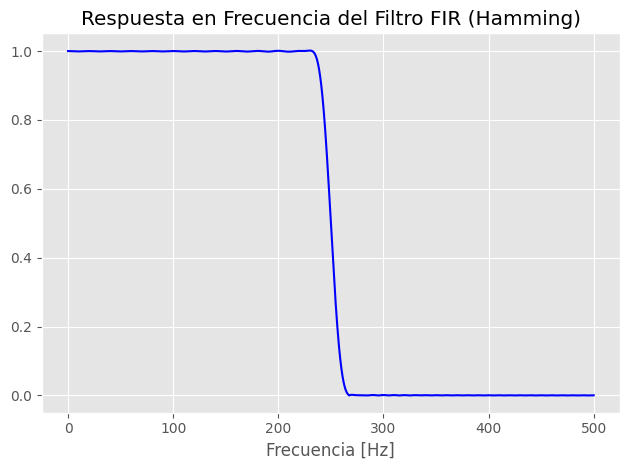

In [53]:
plt.plot(0.5*Fs*freq_response_hamming/np.pi, np.abs(freqs_hamming), 'b')
plt.title('Respuesta en Frecuencia del Filtro FIR (Hamming)')
plt.xlabel('Frecuencia [Hz]')
plt.grid(True)
plt.tight_layout()

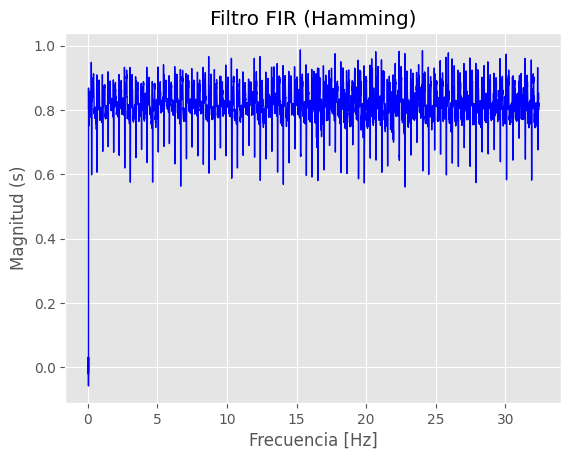

In [54]:
ecg_fir2 = lfilter(fir_filter_hamming, 1.0, senal_sin60Hz)
plt.plot(t,ecg_fir2, lw=1, color='blue')
plt.title('Filtro FIR (Hamming)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel("Magnitud (s)")
plt.savefig("FIR_EJERCICIO_hamming.jpg", format='jpg', dpi=300, bbox_inches='tight')

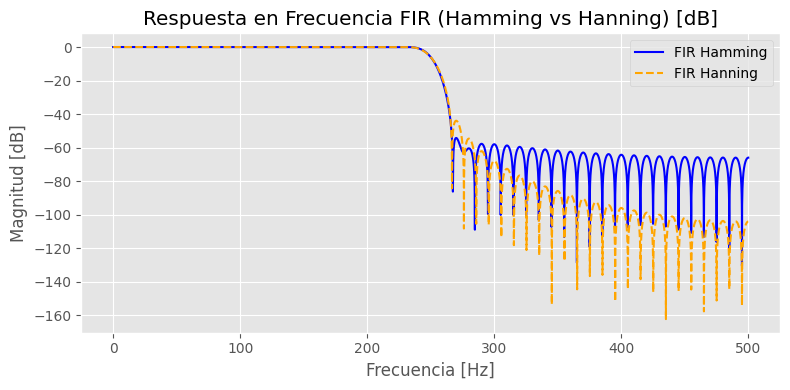

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

Fs = 1000  # Frecuencia de muestreo (Hz)
FC_FIR = 0.5  # Frecuencia de corte normalizada (0-1), 1=Nyquist
num_taps = 101

# Crear filtros
fir_filter_hamming = scipy.signal.firwin(num_taps, FC_FIR, window='hamming')
fir_filter_hanning = scipy.signal.firwin(num_taps, FC_FIR, window='hann')

# Obtener respuesta en frecuencia
w_hamming, h_hamming = scipy.signal.freqz(fir_filter_hamming, worN=8000)
w_hanning, h_hanning = scipy.signal.freqz(fir_filter_hanning, worN=8000)

# Convertir a Hz
freqs_hz = w_hamming * Fs / (2 * np.pi)

# Calcular magnitud en decibeles
hamming_db = 20 * np.log10(np.abs(h_hamming))
hanning_db = 20 * np.log10(np.abs(h_hanning))

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(freqs_hz, hamming_db, label='FIR Hamming', color='blue')
plt.plot(freqs_hz, hanning_db, label='FIR Hanning', color='orange', linestyle='--')

plt.title('Respuesta en Frecuencia FIR (Hamming vs Hanning) [dB]')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("respuesta_en_db_Basal.jpg", dpi=300)
plt.show()